In [15]:
%%capture
!pip install setuptools wheel
!pip install "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Exploratory Data Analysis 

In [59]:
def preprocess_data(data):
    data = data.set_index('Date')
    data['TP'] = data.apply(
        lambda x: np.mean(x[['High', 'Low', 'Close']]), axis=1
    )
    data['target'] = data.TP.shift(-1)
    data = data.dropna()
    data = data.drop(columns=['TP'])
    return data

data = pd.read_csv("data/APPL_raw_data.csv")
data = preprocess_data(data)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,target
Date,,,,,,,,,,
1997-01-02,0.161046,0.161999,0.158188,0.160093,143113600,0.0,0.0,159.4,5.25,0.165176
1997-01-03,0.161046,0.169623,0.160093,0.165811,119716800,0.0,0.0,159.4,5.25,0.135873
1997-01-06,0.134364,0.139843,0.131506,0.136270,1882832000,0.0,0.0,159.4,5.25,0.135317
1997-01-07,0.138176,0.139129,0.133411,0.133411,976931200,0.0,0.0,159.4,5.25,0.135635
1997-01-08,0.139128,0.140082,0.132458,0.134364,1100131200,0.0,0.0,159.4,5.25,0.134999


## Data Prepartion

In order not to overfit our model, we split the data into train and test linearly by timeline instead of sampling. 

In [60]:
DAYS_FOR_TESTING = 60

def split_data(data):    
    train = data.iloc[:-DAYS_FOR_TESTING, :]
    test = data.iloc[-DAYS_FOR_TESTING:, :]
    return train, test

In [61]:
train, test = split_data(data)
train.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,target
Date,,,,,,,,,,
1997-01-02,0.161046,0.161999,0.158188,0.160093,143113600,0.0,0.0,159.4,5.25,0.165176
1997-01-03,0.161046,0.169623,0.160093,0.165811,119716800,0.0,0.0,159.4,5.25,0.135873
1997-01-06,0.134364,0.139843,0.131506,0.136270,1882832000,0.0,0.0,159.4,5.25,0.135317
1997-01-07,0.138176,0.139129,0.133411,0.133411,976931200,0.0,0.0,159.4,5.25,0.135635
1997-01-08,0.139128,0.140082,0.132458,0.134364,1100131200,0.0,0.0,159.4,5.25,0.134999


In [62]:
train.shape, test.shape

((6397, 10), (60, 10))

In [63]:
predictor = TabularPredictor(label='target', eval_metric='root_mean_squared_error').fit(train, time_limit=600, presets='best_quality')
predictor.fit_summary()

No path specified. Models will be saved in: "AutogluonModels/ag-20220830_212906/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220830_212906/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6397
Train Data Columns: 9
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (180.12130413520288, 0.0995818702463001, 22.70614, 37.53803)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting 

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -0.728931      14.062434  320.210186                0.000771           0.676293            2       True         12
1     ExtraTreesMSE_BAG_L1  -0.735487       0.312097    2.610729                0.312097           2.610729            1       True          7
2      WeightedEnsemble_L3  -0.739354      15.167219  480.685579                0.000734           0.310849            3       True         19
3     ExtraTreesMSE_BAG_L2  -0.745864      14.683353  349.230021                0.307239           4.159554            2       True         17
4   RandomForestMSE_BAG_L1  -0.749843       0.303635    7.246300                0.303635           7.246300            1       True          5
5   RandomForestMSE_BAG_L2  -0.752430      14.690294  362.350791                

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFa

In [98]:
test['prediction'] = predictor.predict(test)

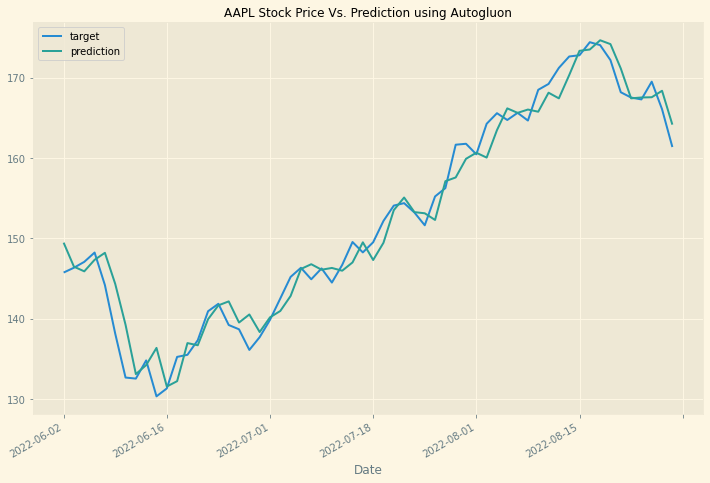

In [99]:
test.plot(y=['target', 'prediction'], kind='line', figsize=(12,8))
plt.title("AAPL Stock Price Vs. Prediction using Autogluon", size=12)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

In [105]:
# Evaluation metrics
mae = mean_absolute_error(test['target'], test['prediction'])
rmse = mean_squared_error(test['target'], test['prediction'], squared=False)

pd.DataFrame({
    "Stock": ["AAPL", "MMM", "WDC"],
    'MAE': [mae, "default", 100],
    "RMSE": [rmse, "default",  5],
})

,Stock,MAE,RMSE
0,AAPL,1.820064,2.405067
1,MMM,default,default
2,WDC,100,5


## Traning Evaluation

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [92]:
x_train_rf, y_train_rf = train.loc[:, train.columns != 'target'], train['target']

x_test_rf, y_test_rf = test.loc[:, test.columns != 'target'], test['target']

In [84]:
# Instanciating a Regressor and Training
regressor_rf = RandomForestRegressor(n_estimators = 1000)

# Training
regressor_rf.fit(x_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=1000)

In [93]:
prediction_rf = regressor_rf.predict(x_test_rf)
prediction_rf

array([149.77063696, 146.73075814, 145.62957976, 147.78799288,
       148.6695923 , 144.81686094, 138.61659125, 131.41419643,
       132.92867013, 134.70161419, 129.39589413, 131.0232193 ,
       135.57105193, 135.34309256, 140.67177042, 141.60442539,
       141.97840826, 138.57742708, 140.91596292, 137.49223105,
       140.68690184, 141.37032182, 142.8058849 , 146.14573414,
       146.83358278, 146.18296652, 146.3175328 , 146.19474758,
       147.51739014, 148.63034014, 146.55132876, 149.66013598,
       153.64735764, 155.82906745, 152.60268114, 152.47947412,
       151.88791397, 157.14459919, 157.29264263, 160.49515038,
       161.05227284, 160.60257476, 164.04426241, 166.61127267,
       166.3179766 , 166.62673715, 166.27048486, 168.1225139 ,
       167.34843852, 169.91497624, 174.85368414, 174.41817862,
       175.0133115 , 174.6052435 , 170.367487  , 167.50941163,
       167.67246574, 167.7753973 , 168.76789004, 163.68123644])

Text(0.5, 1.0, 'AAPL Stock Price Vs. Prediction using RF Regressor')

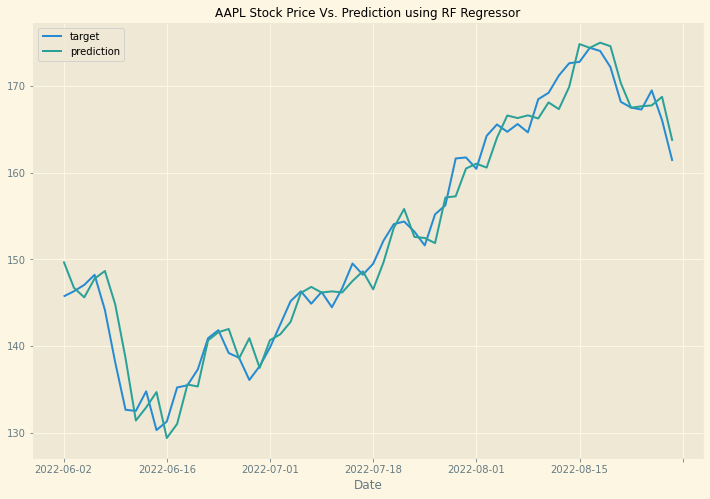

In [101]:
result_rf = pd.DataFrame(y_test_rf)
result_rf['prediction'] = prediction_rf
# result_rf.plot(x='Date', y=['TP', 'prediction'], kind='line', figsize=(12,8))
result_rf.plot(figsize=(12,8))
plt.title("AAPL Stock Price Vs. Prediction using RF Regressor", size=12)

In [104]:
# Evaluation metrics
mae = mean_absolute_error(result_rf['target'], result_rf['prediction'])
rmse = mean_squared_error(result_rf['target'], result_rf['prediction'], squared=False)

pd.DataFrame({
    "Stock": ["AAPL", "MMM", "WDC"],
    'MAE': [mae, "default", 100],
    "RMSE": [rmse, "default",  5],
})

,Stock,MAE,RMSE
0,AAPL,1.871204,2.427932
1,MMM,default,default
2,WDC,100,5


## Feature Engineering

In [7]:
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,TP,target
0,1997-01-02,0.161046,0.161999,0.158188,0.160093,143113600,0.0,0.0,159.4,5.25,0.160093,0.165176
1,1997-01-03,0.161046,0.169623,0.160093,0.165811,119716800,0.0,0.0,159.4,5.25,0.165176,0.135873
2,1997-01-06,0.134364,0.139843,0.131506,0.136270,1882832000,0.0,0.0,159.4,5.25,0.135873,0.135317
3,1997-01-07,0.138176,0.139129,0.133411,0.133411,976931200,0.0,0.0,159.4,5.25,0.135317,0.135635
4,1997-01-08,0.139128,0.140082,0.132458,0.134364,1100131200,0.0,0.0,159.4,5.25,0.135635,0.134999


In [13]:
data_enriched = data.copy()

# Creating 10 lags for starting
for i in range (5, 0, -1):
    data_enriched['t-' + str(i)] = data_enriched.TP.shift(i)

# Moving Avg of 2 weeks
data_enriched["rolling"] = data_enriched.TP.rolling(window = 14).mean()

data_enriched.dropna()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,TP,target,t-5,t-4,t-3,t-2,t-1,rolling
13,1997-01-21,0.129600,0.131505,0.128647,0.131505,284827200,0.0,0.0,159.400,5.25,0.130553,0.131347,0.137223,0.133094,0.128329,0.128329,0.129123,0.137887
14,1997-01-22,0.132458,0.133411,0.129600,0.131029,205620800,0.0,0.0,159.400,5.25,0.131347,0.131505,0.133094,0.128329,0.128329,0.129123,0.130553,0.135833
15,1997-01-23,0.131505,0.132458,0.130553,0.131505,172345600,0.0,0.0,159.400,5.25,0.131505,0.129600,0.128329,0.128329,0.129123,0.130553,0.131347,0.133428
16,1997-01-24,0.131505,0.131505,0.128647,0.128647,188283200,0.0,0.0,159.400,5.25,0.129600,0.128329,0.128329,0.129123,0.130553,0.131347,0.131505,0.132980
17,1997-01-27,0.130553,0.131505,0.126741,0.126741,214043200,0.0,0.0,159.400,5.25,0.128329,0.127376,0.129123,0.130553,0.131347,0.131505,0.129600,0.132481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6452,2022-08-22,169.690002,169.860001,167.139999,167.570007,69026800,0.0,0.0,295.271,1.21,168.190002,167.529999,172.643336,172.800003,174.423335,174.056661,172.190002,169.150608
6453,2022-08-23,167.080002,168.710007,166.649994,167.229996,54147100,0.0,0.0,295.271,1.21,167.529999,167.296666,172.800003,174.423335,174.056661,172.190002,168.190002,169.384048
6454,2022-08-24,167.320007,168.110001,166.250000,167.529999,53841500,0.0,0.0,295.271,1.21,167.296666,169.506668,174.423335,174.056661,172.190002,168.190002,167.529999,169.506667
6455,2022-08-25,168.779999,170.139999,168.350006,170.029999,51218200,0.0,0.0,295.271,1.21,169.506668,166.076665,174.056661,172.190002,168.190002,167.529999,167.296666,169.847620


In [19]:
train_enriched, test_enriched = split_data(data_enriched)
train_enriched.shape, test_enriched.shape

((6397, 18), (60, 18))

In [20]:
predictor_enhanced = TabularPredictor(label='target', eval_metric='root_mean_squared_error').fit(train_enriched, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220830_175930/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220830_175930/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    6397
Train Data Columns: 17
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (180.12130413520288, 0.0995818702463001, 22.70614, 37.53803)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting

NameError: name 'predictor' is not defined

In [21]:
predictor_enhanced.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -0.604631       1.560146   39.270676                0.000959           0.580511            2       True          9
1    KNeighborsDist_BAG_L1  -0.646242       1.107245    0.007780                1.107245           0.007780            1       True          2
2      WeightedEnsemble_L3  -0.669234      14.882289  490.390491                0.000780           0.360286            3       True         15
3   RandomForestMSE_BAG_L2  -0.679366      13.057135  415.271952                0.318324          23.608165            2       True         12
4     ExtraTreesMSE_BAG_L2  -0.680790      13.050091  397.316162                0.311279           5.652375            2       True         14
5    KNeighborsUnif_BAG_L1  -0.721068       1.744512    0.012686                

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -0.7210683155847103,
  'KNeighborsDist_BAG_L1': -0.6462419412353013,
  'LightGBMXT_BAG_L1': -0.920319666669546,
  'LightGBM_BAG_L1': -

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Date'>

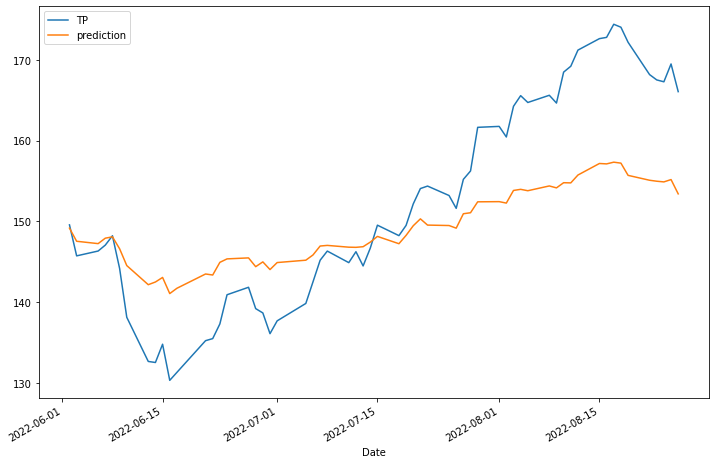

In [23]:
test_enriched['prediction'] = predictor_enhanced.predict(test_enriched)
test_enriched.plot(x='Date', y=['TP', 'prediction'], kind='line', figsize=(12,8))

In [24]:
test_enriched

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,CPIAUCSL,FEDFUNDS,TP,target,t-5,t-4,t-3,t-2,t-1,rolling,prediction
6397,2022-06-02,147.624943,151.060174,146.656287,151.000259,72348100,0.00,0.0,295.328,1.21,149.572240,145.734239,140.022170,141.556695,147.987770,148.573631,149.169460,143.938634,149.164505
6398,2022-06-03,146.696225,147.764748,144.259623,145.178345,88570300,0.00,0.0,295.328,1.21,145.734239,146.333404,141.556695,147.987770,148.573631,149.169460,149.572240,143.926508,147.542648
6399,2022-06-06,146.826051,148.363924,144.699001,145.937286,71598400,0.00,0.0,295.328,1.21,146.333404,147.065718,147.987770,148.573631,149.169460,149.572240,145.734239,143.982858,147.250168
6400,2022-06-07,144.149771,148.793314,143.900117,148.503723,67808200,0.00,0.0,295.328,1.21,147.065718,148.224120,148.573631,149.169460,149.572240,145.734239,146.333404,143.890605,147.923920
6401,2022-06-08,148.373911,149.662115,147.255470,147.754776,53950200,0.00,0.0,295.328,1.21,148.224120,144.173067,149.169460,149.572240,145.734239,146.333404,147.065718,144.299799,148.091614
6402,2022-06-09,146.875982,147.744771,142.332291,142.442139,69473000,0.00,0.0,295.328,1.21,144.173067,138.124804,149.572240,145.734239,146.333404,147.065718,148.224120,144.716124,146.613022
6403,2022-06-10,140.085413,140.564743,136.869879,136.939789,91437900,0.00,0.0,295.328,1.21,138.124804,132.655732,145.734239,146.333404,147.065718,148.224120,144.173067,144.812420,144.531052
6404,2022-06-13,132.685684,135.012454,131.257675,131.697067,122207100,0.00,0.0,295.328,1.21,132.655732,132.525908,146.333404,147.065718,148.224120,144.173067,138.124804,144.206119,142.163452
6405,2022-06-14,132.945333,133.704274,131.297613,132.575836,84784300,0.00,0.0,295.328,1.21,132.525908,134.789442,147.065718,148.224120,144.173067,138.124804,132.655732,143.694211,142.497467
6406,2022-06-15,134.103724,137.149496,131.976688,135.242142,91533000,0.00,0.0,295.328,1.21,134.789442,130.315653,148.224120,144.173067,138.124804,132.655732,132.525908,143.320445,143.061417


In [27]:
# Evaluation metrics

mae = mean_absolute_error(test_enriched['target'], test_enriched['prediction'])
rmse = mean_squared_error(test_enriched['target'], test_enriched['prediction'], squared=False)

pd.DataFrame({
    "Stock": ["AAPL", "MMM", "WDC"],
    'MAE': [mae, "default", 100],
    "MSE": [mse, "default",  5],
})

,Stock,MAE,MSE
0,AAPL,7.581423,83.060202
1,MMM,default,default
2,WDC,100,5
